In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, classification_report, confusion_matrix, average_precision_score
import matplotlib.pyplot as plt
import time
import copy
import gc
from torch.utils.tensorboard import SummaryWriter

%matplotlib inline

In [2]:
torch.cuda.set_device(0)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
device

device(type='cuda')

In [4]:
writer = SummaryWriter(log_dir="runs")

In [5]:
BATCH_SIZE = 64
NUM_WORKERS = 4

## Wczytanie i transformacja danych

In [6]:
class_names = ['aeroplane', 'bicycle', 'bird', 'boat',
                     'bottle', 'bus', 'car', 'cat', 'chair',
                     'cow', 'diningtable', 'dog', 'horse',
                     'motorbike', 'person', 'pottedplant',
                     'sheep', 'sofa', 'train', 'tvmonitor']

In [7]:
# transforms labels to one-hot vectors
def label_transform(image):
    ls = []
    for d in image['annotation']['object']:
        ls.append(class_names.index(d['name']))

    indices = np.zeros(shape=(len(class_names)))
    for d in image['annotation']['object']:
        indices[class_names.index(d['name'])] = 1

    return torch.from_numpy(indices)

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'trainval': transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [9]:
image_datasets = {x: torchvision.datasets.voc.VOCDetection(root=f"data/{x}", year="2007", image_set=x, download=True, transform=data_transforms[x], target_transform=label_transform)
                  for x in ['train', 'trainval', 'test']}

Using downloaded and verified file: data/train/VOCtrainval_06-Nov-2007.tar
Extracting data/train/VOCtrainval_06-Nov-2007.tar to data/train
Using downloaded and verified file: data/trainval/VOCtrainval_06-Nov-2007.tar
Extracting data/trainval/VOCtrainval_06-Nov-2007.tar to data/trainval
Using downloaded and verified file: data/test/VOCtest_06-Nov-2007.tar
Extracting data/test/VOCtest_06-Nov-2007.tar to data/test


In [10]:
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
               for x in ['train', 'trainval', 'test']}

In [11]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'trainval', 'test']}

## Wizualizacja kilku zdjęć ze zbioru po transformacji

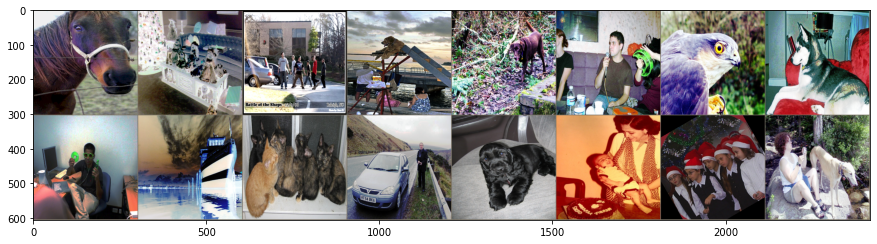

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

dataiter = iter(dataloaders['train'])
random_images, random_labels = dataiter.next()
random_images = random_images[:16]

plt.rcParams['figure.figsize'] = 15, 10
imshow(torchvision.utils.make_grid(random_images))

In [13]:
dataset_sizes

{'train': 2501, 'trainval': 5011, 'test': 4952}

## Wybór typu transfer learningu
Rozmiar zbioru danych ImageNet, na którym była wytrenowana większość modeli używanych w transfer learningu wynosi 14197122 - a więc jest znacznie większy od zbioru danych Pascal VOC 2007. Ponadto większość klas ze zbioru Pascal VOC 2007 zawiera się w zbiorze ImageNet, przy czym w zbiorze ImageNet klasy te są często bardziej specyficzne.<br>
Jako że zbiór Pascal VOC 2007 jest mały w porównaniu do ImageNet, w przypadku dotrenowywania wybranego modelu istniałoby duże ryzyko przeuczenia modelu. Ponadto jako że klasy Pascal VOC 2007 zawierają się w zbiorze ImageNet, to wysoko-poziomowe atrybuty wybranego modelu powinny być odpowiednie i do zbioru Pascal VOC 2007.<br>
Dlatego też, wagi wybranej architektury zostaną zamrożone i zostaną wytrenowane tylko ostatnie warstwy liniowe klasyfikatora (głowa klasyfikatora).

### Rozkład klas w zbiorze treningowym

In [14]:
count_dict = {class_name: 0 for class_name in class_names}
for i in range(len(image_datasets['train'])):
    for target in np.array(class_names)[np.where(image_datasets['train'][i][1])]:
        count_dict[target] +=1

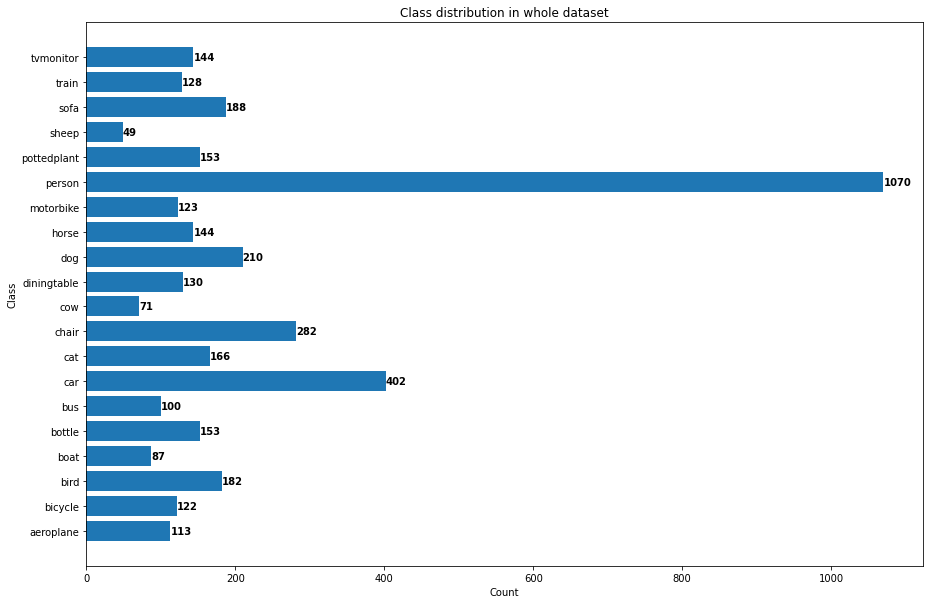

In [15]:
plt.figure(figsize=(15,10))
plt.barh(y=list(count_dict.keys()), width=list(count_dict.values()))
plt.title('Class distribution in whole dataset')
plt.xlabel('Count')
plt.ylabel('Class')
for i, v in enumerate(list(count_dict.values())):
    plt.text(v, i, str(v), color='black', va='center', fontweight='bold')

In [16]:
def ap_score(y_true, y_scores):
    return np.sum([average_precision_score(y_true = y_true[i], y_score = y_scores[i]) for i in range(y_true.shape[0])])

In [17]:
def train_model(model, criterion, optimizer, scheduler, threshold=0.5, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_map = 0.0
    stats = {
        'train': {
            'iterations' : [],
            'losses': [],
            'micro_f1': [],
            'samples_f1': [],
            'maps': []
        },
        'trainval': {
            'iterations' : [],
            'losses': [],
            'micro_f1': [],
            'samples_f1': [],
            'maps': []
        }
    }

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'trainval']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_micro_f1 = 0.0
            running_samples_f1 = 0.0
            running_ap = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_micro_f1 += f1_score(y_true=labels.cpu().detach().numpy(), y_pred=(torch.sigmoid(outputs).cpu().detach().numpy() > threshold), average="micro")
                running_samples_f1 += f1_score(y_true=labels.cpu().detach().numpy(), y_pred=(torch.sigmoid(outputs).cpu().detach().numpy() > threshold), average="samples")
                running_ap += ap_score(y_true=labels.cpu().detach().numpy(), y_scores=torch.sigmoid(outputs).cpu().detach().numpy())

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_micro_f1 = running_micro_f1 / dataset_sizes[phase]
            epoch_samples_f1 = running_samples_f1 / dataset_sizes[phase]
            epoch_map = running_ap / dataset_sizes[phase]

            stats[phase]['iterations'].append(epoch)
            stats[phase]['losses'].append(epoch_loss)
            stats[phase]['micro_f1'].append(epoch_micro_f1)
            stats[phase]['samples_f1'].append(epoch_samples_f1)
            stats[phase]['maps'].append(epoch_map)

            print('{} Loss: {:.4f} Mean Average Precision: {:.4f} Mean Micro F1: {:.4f} Mean Samples F1: {:.4f}'.format(
                phase, epoch_loss, epoch_map, epoch_micro_f1, epoch_samples_f1))
            writer.add_scalar(f"{phase} loss", epoch_loss, epoch)
            writer.add_scalar(f"{phase} mean average precision", epoch_map, epoch)
            writer.add_scalar(f"{phase} micro f1", epoch_micro_f1, epoch)
            writer.add_scalar(f"{phase} samples f1", epoch_samples_f1, epoch)

            # clear variables
            del inputs, labels, outputs
            gc.collect()
            torch.cuda.empty_cache()

            # deep copy the model
            if phase == 'trainval' and epoch_map > best_map:
                best_map = epoch_map
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Mean Average Precision: {:4f}'.format(best_map))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, stats

In [18]:
def test_model(model, criterion, threshold=0.5):

    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_micro_f1 = 0.0
    running_samples_f1 = 0.0
    running_ap = 0.0
    y_true_all = []
    y_pred_all = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.sigmoid(outputs) > threshold

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_micro_f1 += f1_score(y_true=labels.cpu().detach().numpy(), y_pred=(torch.sigmoid(outputs).cpu().detach().numpy() > threshold), average="micro")
            running_samples_f1 += f1_score(y_true=labels.cpu().detach().numpy(), y_pred=(torch.sigmoid(outputs).cpu().detach().numpy() > threshold), average="samples")
            running_ap += ap_score(y_true=labels.cpu().detach().numpy(), y_scores=torch.sigmoid(outputs).cpu().detach().numpy())
            y_pred_all.extend(preds.cpu().detach().numpy())
            y_true_all.extend(labels.cpu().detach().numpy())

    mean_loss = running_loss / dataset_sizes['test']
    mean_micro_f1 = running_micro_f1 / dataset_sizes['test']
    mean_samples_f1 = running_samples_f1 / dataset_sizes['test']
    mean_ap = running_ap / dataset_sizes['test']

    print('Mean Loss: {:.4f} Mean Average Precision: {:.4f} Mean Micro F1: {:.4f} Mean Samples F1: {:.4f}'.format(mean_loss, mean_ap, mean_micro_f1, mean_samples_f1))
    return y_true_all,y_pred_all

In [19]:
def visualize_model(model, threshold=0.5, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.sigmoid(outputs) > threshold

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                print('predicted: {}, ground truth: {}'.format(" ".join([class_names[i] for i in range(len(preds[j])) if preds[j][i]]),  " ".join([class_names[i] for i in range(len(labels[j])) if labels[j][i]])))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [20]:
def plot_training(stats):
    plt.figure(figsize=(18,4))
    plt.subplot(1,4,1)
    plt.title("Training Curve")
    plt.plot(stats['train']['iterations'], stats['train']['losses'], label="Train")
    plt.plot(stats['trainval']['iterations'], stats['trainval']['losses'], label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')

    plt.subplot(1,4,2)
    plt.title("Training Curve")
    plt.plot(stats['train']['iterations'], stats['train']['micro_f1'], label="Train")
    plt.plot(stats['trainval']['iterations'], stats['trainval']['micro_f1'], label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Micro F1")
    plt.legend(loc='best')

    plt.subplot(1,4,3)
    plt.title("Training Curve")
    plt.plot(stats['train']['iterations'], stats['train']['samples_f1'], label="Train")
    plt.plot(stats['trainval']['iterations'], stats['trainval']['samples_f1'], label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Samples F1")
    plt.legend(loc='best')

    plt.subplot(1,4,4)
    plt.title("Training Curve")
    plt.plot(stats['train']['iterations'], stats['train']['maps'], label="Train")
    plt.plot(stats['trainval']['iterations'], stats['trainval']['maps'], label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Mean Average Precision")
    plt.legend(loc='best')

    plt.show()

# Trening modelu
Wybrałem architekturę ResNet ze względu na stosunkowo małą zajętość pamięciową GPU oraz na to, że osiąga ona dobre wyniki w tym zadaniu.

In [21]:
model_conv = models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.avgpool = nn.AdaptiveAvgPool2d(output_size=1)
model_conv.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.Linear(256, len(class_names))
)

model_conv = model_conv.to(device)

In [22]:
criterion = nn.BCEWithLogitsLoss(reduction="sum")
optimizer_conv = optim.Adam(model_conv.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [23]:
model_conv, stats = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, threshold=0.5, num_epochs=20)

Epoch 0/19
----------
train Loss: 293.2531 Mean Average Precision: 0.6021 Mean Micro F1: 0.0057 Mean Samples F1: 0.0045
trainval Loss: 191.1715 Mean Average Precision: 0.7889 Mean Micro F1: 0.0100 Mean Samples F1: 0.0090

Epoch 1/19
----------
train Loss: 183.3010 Mean Average Precision: 0.8016 Mean Micro F1: 0.0095 Mean Samples F1: 0.0084
trainval Loss: 141.4964 Mean Average Precision: 0.8896 Mean Micro F1: 0.0115 Mean Samples F1: 0.0111

Epoch 2/19
----------
train Loss: 156.5378 Mean Average Precision: 0.8564 Mean Micro F1: 0.0109 Mean Samples F1: 0.0101
trainval Loss: 144.8456 Mean Average Precision: 0.8743 Mean Micro F1: 0.0114 Mean Samples F1: 0.0112

Epoch 3/19
----------
train Loss: 150.2304 Mean Average Precision: 0.8619 Mean Micro F1: 0.0111 Mean Samples F1: 0.0105
trainval Loss: 118.3968 Mean Average Precision: 0.9130 Mean Micro F1: 0.0125 Mean Samples F1: 0.0124

Epoch 4/19
----------
train Loss: 136.2452 Mean Average Precision: 0.8791 Mean Micro F1: 0.0115 Mean Samples F1:

In [24]:
model_conv

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

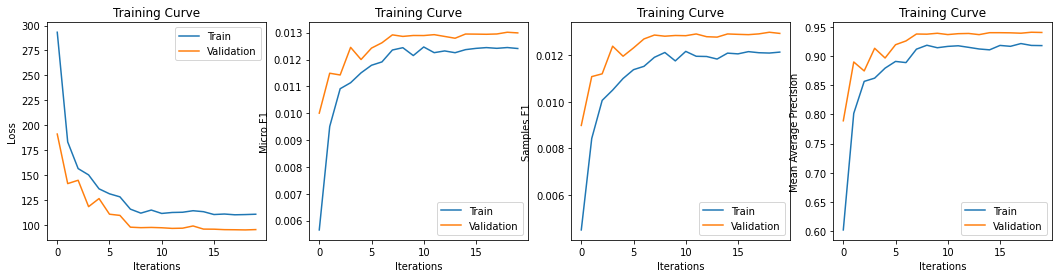

In [25]:
plot_training(stats)

#### Pokazanie statystyk w Tensorboardzie

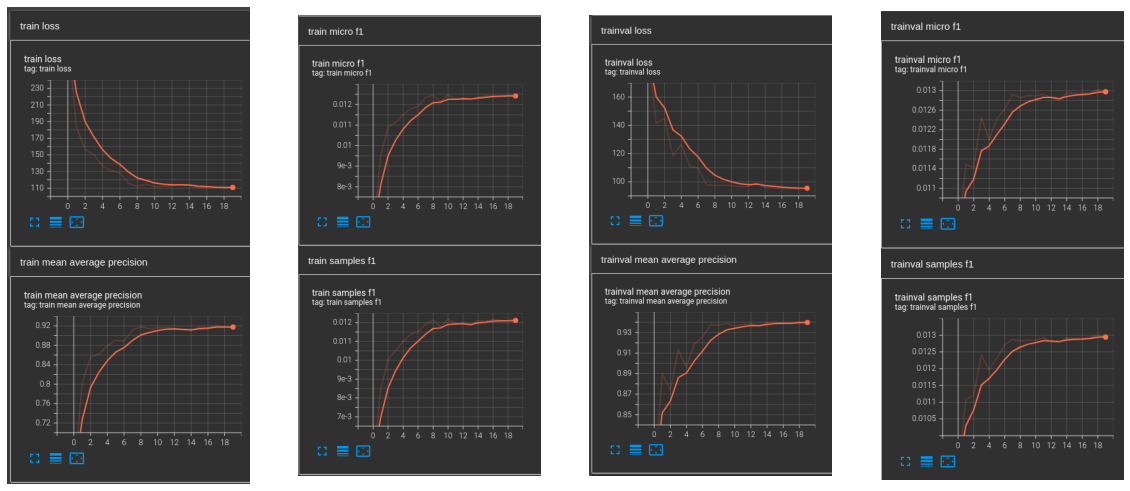

In [33]:
from PIL import Image
plt.figure(figsize=(20,10))
for i in range(1, 5):
    ax = plt.subplot(1, 4, i)
    ax.axis("off")
    plt.imshow(Image.open(f"tensorboard/stats{i}.png"))

# Ewaluacja modelu

predicted: dog person, ground truth: dog person


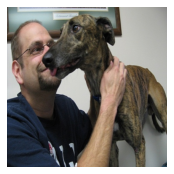

predicted: boat person, ground truth: boat person


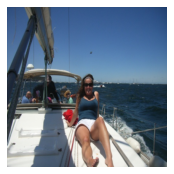

predicted: chair person sofa, ground truth: bottle chair person sofa


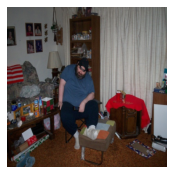

predicted: boat person, ground truth: boat person


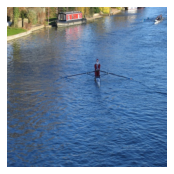

predicted: bicycle person, ground truth: bicycle person


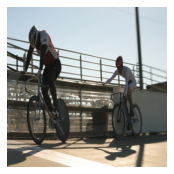

predicted: horse person, ground truth: horse person


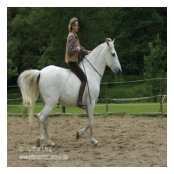

In [26]:
visualize_model(model_conv)

### Statystyki modelu

In [27]:
y_true, y_pred = test_model(model_conv, criterion)

Mean Loss: 102.8615 Mean Average Precision: 0.9277 Mean Micro F1: 0.0126 Mean Samples F1: 0.0126


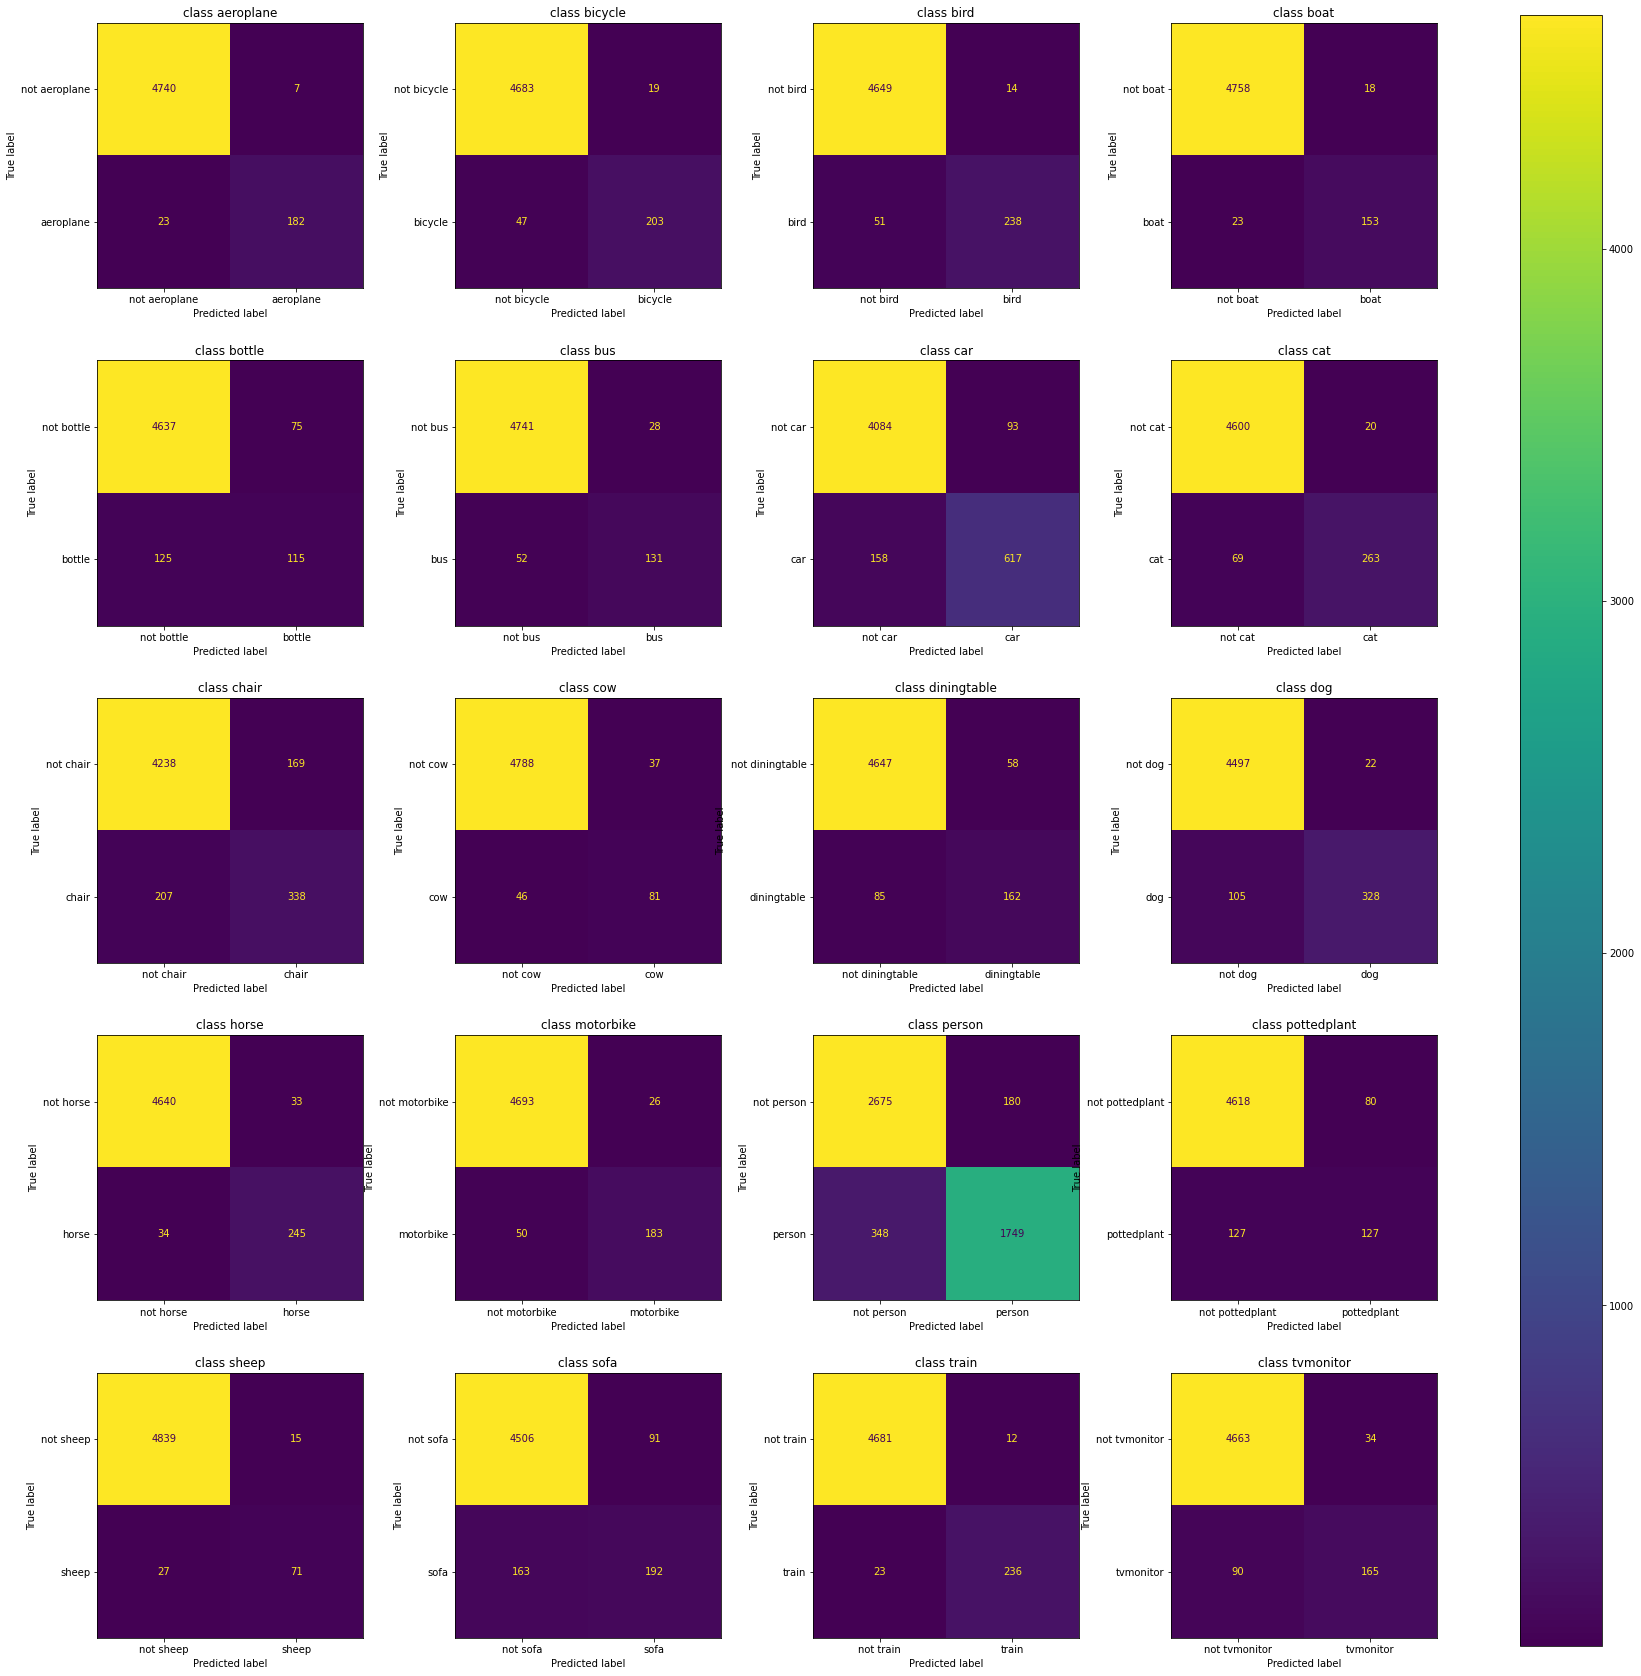

In [28]:
f, axes = plt.subplots(5, 4, figsize=(30, 30))
axes = axes.ravel()
for i in range(len(class_names)):
    disp = ConfusionMatrixDisplay(confusion_matrix(np.array(y_true)[:, i],
                                                   np.array(y_pred)[:, i]),
                                  display_labels=['not '+class_names[i], class_names[i]])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'class {class_names[i]}')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.35, hspace=0.2)
f.colorbar(disp.im_, ax=axes)
plt.show()

In [29]:
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

              precision    recall  f1-score   support

   aeroplane       0.96      0.89      0.92       205
     bicycle       0.91      0.81      0.86       250
        bird       0.94      0.82      0.88       289
        boat       0.89      0.87      0.88       176
      bottle       0.61      0.48      0.53       240
         bus       0.82      0.72      0.77       183
         car       0.87      0.80      0.83       775
         cat       0.93      0.79      0.86       332
       chair       0.67      0.62      0.64       545
         cow       0.69      0.64      0.66       127
 diningtable       0.74      0.66      0.69       247
         dog       0.94      0.76      0.84       433
       horse       0.88      0.88      0.88       279
   motorbike       0.88      0.79      0.83       233
      person       0.91      0.83      0.87      2097
 pottedplant       0.61      0.50      0.55       254
       sheep       0.83      0.72      0.77        98
        sofa       0.68    

## Wnioski
Zastosowanie wytrenowanego modelu ResNet w tym zadaniu sprawdza się bardzo dobrze. Wytrenowanie samej głowy modelu zajmuje mało czasu. <br>
Udało mi się osiągnąć wartość metryki Mean Average Precision na poziomie 92.7, podczas gdy na obecny stan najskuteczniejsze modele na zbiorze danych Pascal VOC 2007 osiągają wartość tej metryki na poziomie 97.3. Zważając na to, że zastosowałem stosunkowo prostą architekturę ResNet, wyniki można uznać za zadowalające.